For this set of tests, I undid the "heavy box atlas" changes and went back to a model closer to the one from 2018-05-08, but with slightly more reasonable inertias. 

In [18]:
using Revise

In [19]:
using MeshCatMechanisms
using MeshCat
using RigidBodyDynamics
using Flux
using ProgressMeter
using MLDataPattern
using JLD2
using Plots; gr()
using LCPSim
using LearningMPC
using LearningMPC.Models

In [20]:
using Blink

In [21]:
robot = BoxAtlas(add_contacts=false)
mvis = MechanismVisualizer(robot)
open(mvis, Window())

Blink.AtomShell.Window(1, Blink.AtomShell.Electron(Process(`/home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/deps/atom/electron /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Blink/src/AtomShell/main.js port 4704`, ProcessRunning), TCPSocket(RawFD(65) active, 0 bytes waiting), Dict{String,Any}(Pair{String,Any}("callback", Blink.#1))), Blink.Page(3, WebSockets.WebSocket{TCPSocket}(TCPSocket(RawFD(70) active, 0 bytes waiting), true, CONNECTED::WebSockets.ReadyState = 1), Dict{String,Any}(Pair{String,Any}("webio", WebIO.#111),Pair{String,Any}("callback", Blink.#1)), Future(1, 1, 3, Nullable{Any}(true))))

In [22]:
params = MPCParams(robot)
lqrsol = LQRSolution(robot, params, false)
net, loss = LearningMPC.interval_net([22, 32, 32, 1]; regularization=1e-3)
optimizer = Flux.ADAM(Flux.params(net))

net_cost = LearningMPC.LearnedCost(lqrsol, net)

net_mpc_params = MPCParams(robot)
net_mpc_params.horizon = 1
net_mpc_controller = MPCController(robot, net_mpc_params, net_cost, [lqrsol]);

full_mpc_controller = MPCController(robot, params, lqrsol, [lqrsol, net_mpc_controller]);

lqr_mpc_controller = MPCController(robot, (p = MPCParams(robot); p.horizon=1; p), lqrsol, [lqrsol])

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


(::MPCController) (generic function with 1 method)

In [23]:
sample_sink = LearningMPC.MPCSampleSink{Float64}(true)
playback_sink = LearningMPC.PlaybackSink{Float64}(mvis)

full_mpc_controller.callback = LearningMPC.multiplex!(
    sample_sink,
    playback_sink
)

live_viewer = LearningMPC.live_viewer(mvis)

dagger_controller = LearningMPC.multiplex!(
    LearningMPC.dagger_controller(
        full_mpc_controller,
        net_mpc_controller),
    live_viewer
    )

dataset = LearningMPC.Dataset(lqrsol)

collect_into! = let x_init = nominal_state(robot), x0 = MechanismState{Float64}(robot.mechanism)
    function (data::Vector{<:LearningMPC.Sample}, σv)
        empty!(sample_sink)
        copy!(x0, x_init)
        set_velocity!(x0, findjoint(x0.mechanism, "floating_base"),
            [σv * (2 * (rand() - 0.5)), 0.0, 0.0])
#         LearningMPC.randomize!(x0, x_init, 0.0, σv)
        results = LCPSim.simulate(x0, 
            dagger_controller,
            robot.environment, params.Δt, 50, 
            params.lcp_solver;
            termination=x -> configuration(x)[3] > π/4 || configuration(x)[3] < -π/4);
        append!(data, sample_sink.samples)
    end
end

features(s::LearningMPC.Sample) = (s.state, s.mip.objective_bound, s.mip.objective_value)

features (generic function with 1 method)

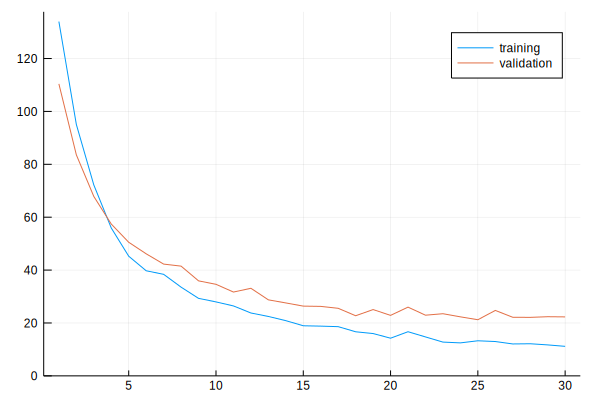

499.881966 seconds (1.13 G allocations: 130.432 GiB, 11.01% gc time)


Progress:   1%|                                         |  ETA: 1 days, 7:31:14

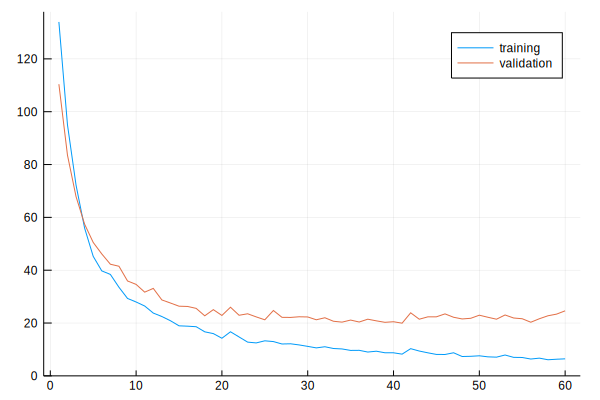

479.565646 seconds (1.14 G allocations: 131.471 GiB, 11.16% gc time)


Progress:   2%|█                                        |  ETA: 1 days, 11:11:29

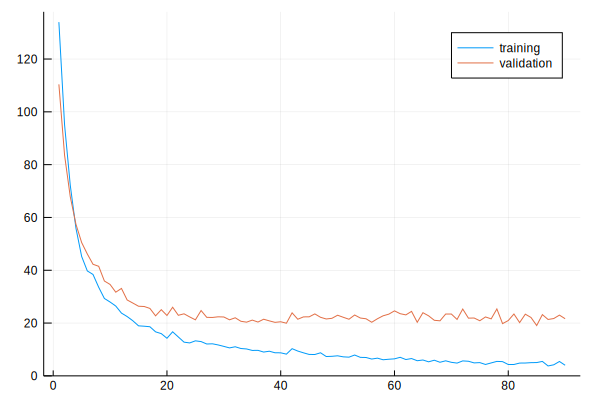

493.985801 seconds (1.15 G allocations: 132.511 GiB, 11.30% gc time)


Progress:   3%|█                                        |  ETA: 1 days, 11:51:49

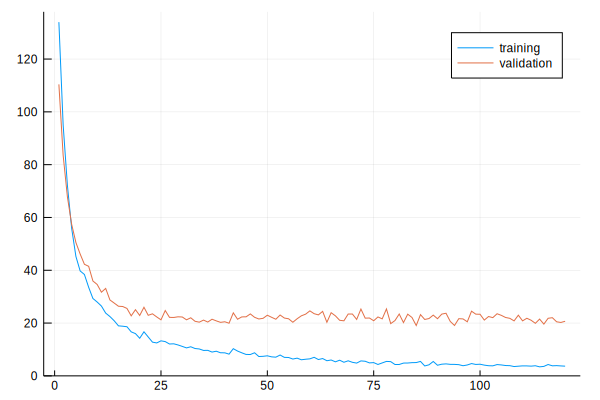

494.769728 seconds (1.16 G allocations: 133.542 GiB, 11.06% gc time)


Progress:   4%|██                                       |  ETA: 1 days, 12:04:50

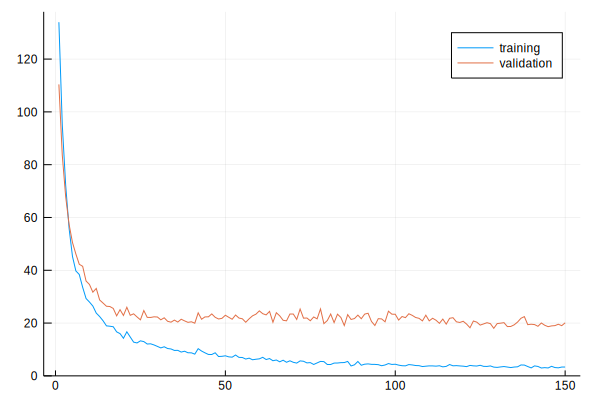

485.191046 seconds (1.17 G allocations: 134.583 GiB, 10.99% gc time)


Progress:   5%|██                                       |  ETA: 1 days, 12:00:44

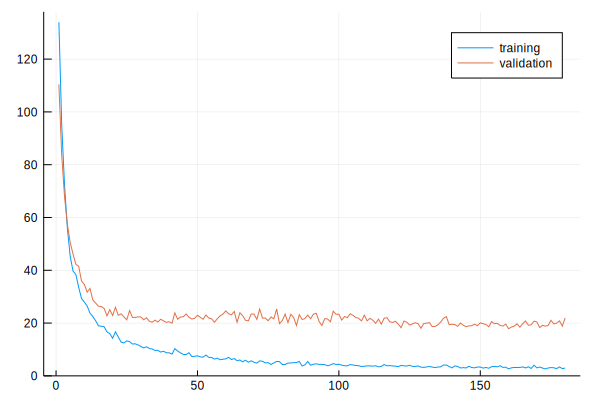

495.032503 seconds (1.18 G allocations: 135.614 GiB, 11.35% gc time)


Progress:   6%|██                                       |  ETA: 1 days, 11:42:44

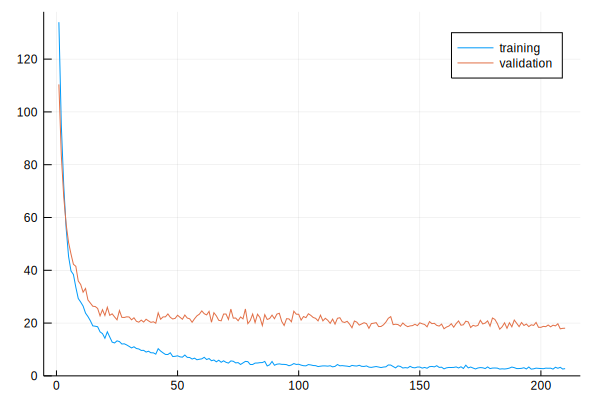

499.282195 seconds (1.18 G allocations: 136.390 GiB, 11.26% gc time)


Progress:   7%|███                                      |  ETA: 1 days, 10:50:16

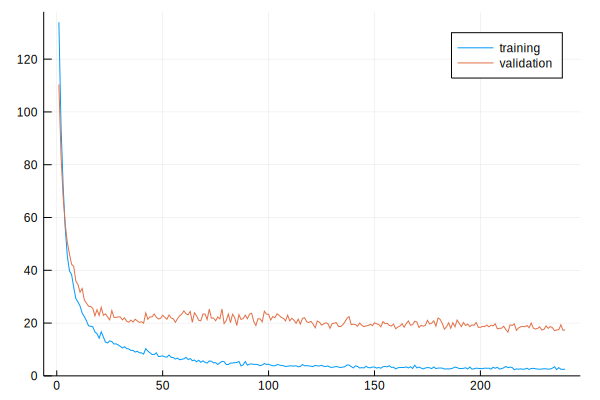

500.774906 seconds (1.19 G allocations: 137.430 GiB, 11.39% gc time)


Progress:   8%|███                                      |  ETA: 1 days, 10:41:03

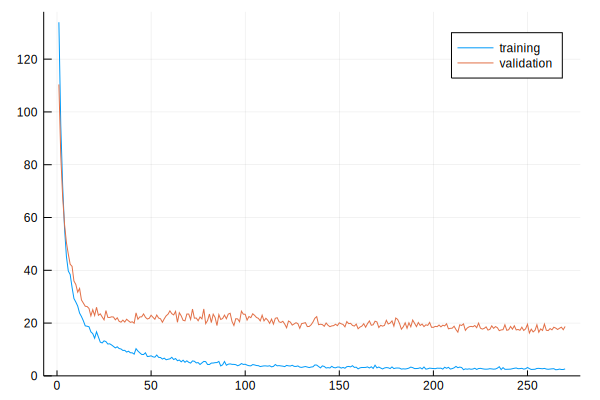

504.002470 seconds (1.20 G allocations: 137.888 GiB, 11.15% gc time)


Progress:   9%|████                                     |  ETA: 1 days, 9:18:25

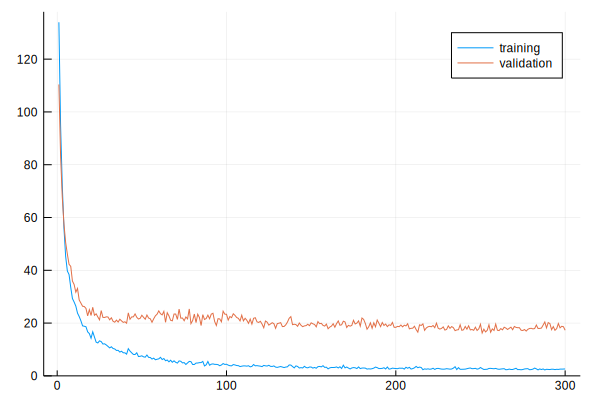

511.901087 seconds (1.21 G allocations: 138.928 GiB, 11.37% gc time)


Progress:  10%|████                                     |  ETA: 1 days, 9:10:40

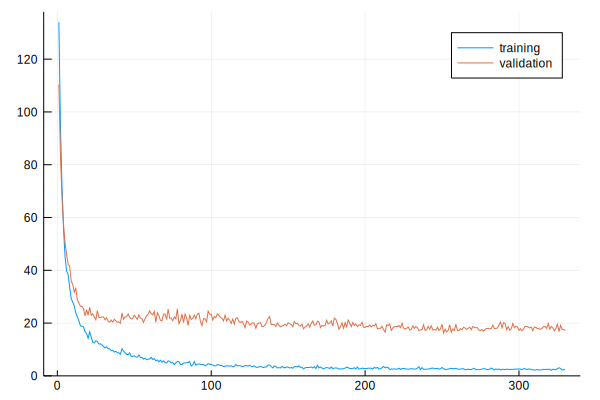

515.062283 seconds (1.22 G allocations: 139.969 GiB, 11.39% gc time)


Progress:  11%|█████                                    |  ETA: 1 days, 9:02:41

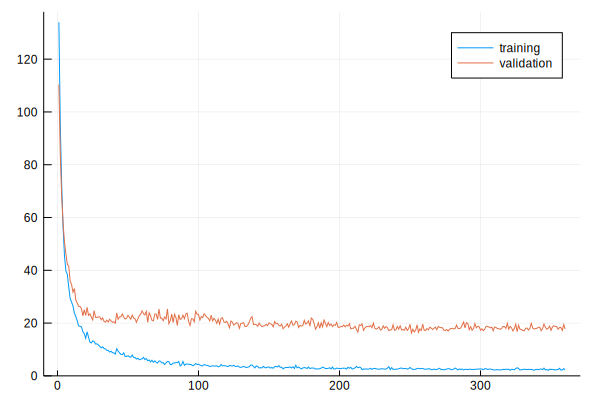

519.853552 seconds (1.22 G allocations: 141.009 GiB, 11.07% gc time)


Progress:  12%|█████                                    |  ETA: 1 days, 8:48:42

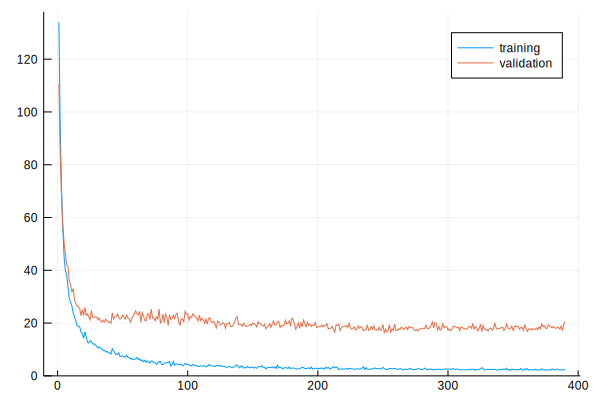

529.891627 seconds (1.23 G allocations: 141.918 GiB, 11.22% gc time)


Progress:  13%|█████                                    |  ETA: 1 days, 8:09:30

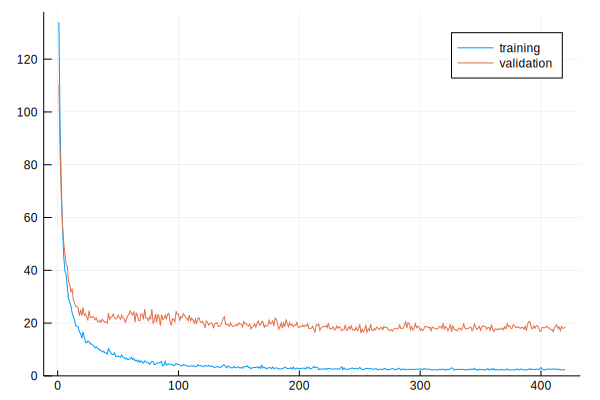

565.112447 seconds (1.24 G allocations: 142.351 GiB, 10.73% gc time)


Progress:  14%|██████                                   |  ETA: 1 days, 7:18:24

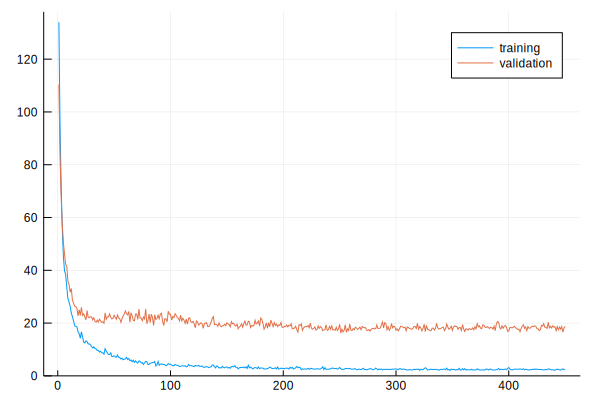

555.122761 seconds (1.24 G allocations: 143.082 GiB, 11.09% gc time)


Progress:  15%|██████                                   |  ETA: 1 days, 6:54:14

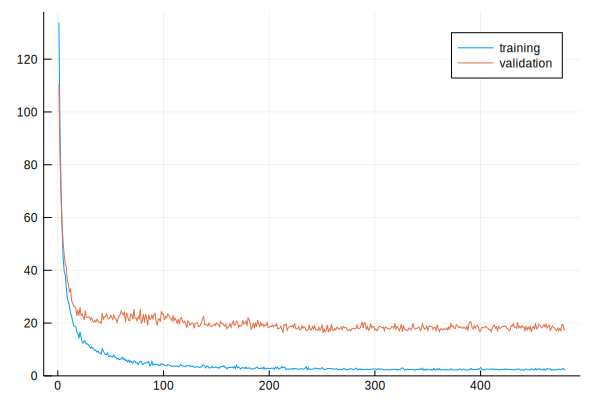

600.627302 seconds (1.25 G allocations: 143.999 GiB, 10.75% gc time)


Progress:  16%|███████                                  |  ETA: 1 days, 6:40:42

LoadError: [91mInterruptException:[39m

Unexpected end of input
 ...when parsing byte with value '0'
Stacktrace:
 [1] _error(::String, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:148
 [2] byteat(::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:58
 [3] chomp_space! at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:115 [inlined]
 [4] parse_value(::JSON.Parser.ParserContext{Dict{String,Any},Int64}, ::JSON.Parser.StreamingParserState{TCPSocket}) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:158
 [5] #parse#2(::Type{Dict{String,Any}}, ::Type{Int64}, ::Function, ::TCPSocket) at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/JSON/src/Parser.jl:406
 [6] macro expansion at /home/rdeits/locomotion/explorations/learning-mpc-2/packages/v0.6/Lazy/src/macros.jl:241 [i

In [24]:
datasets = Vector{LearningMPC.Dataset{Float64}}()
losses = Vector{Tuple{Float64, Float64}}()

all_training_data = if isfile("library.jld2")
    jldopen("library.jld2", "r") do file
        file["training"]
    end
else
    Vector{Tuple{Vector{Float64}, Float64, Float64}}()
end


all_validation_data = if isfile("library.jld2")
    jldopen("library.jld2", "r") do file
        file["testing"]
    end
else
    Vector{Tuple{Vector{Float64}, Float64, Float64}}()
end

N_iter = 100
σv = 2.0

@showprogress for i in 1:N_iter
    dataset = LearningMPC.Dataset(lqrsol)
    for i in 1:2
        collect_into!(dataset.training_data, σv)
    end
    collect_into!(dataset.validation_data, σv)
    append!(all_training_data, features.(dataset.training_data))
    append!(all_validation_data, features.(dataset.validation_data))

    filter!(all_training_data) do sample
        all(isfinite, sample[1]) && !isnan(sample[2]) && !isnan(sample[3])
    end
    filter!(all_validation_data) do sample
        all(isfinite, sample[1]) && !isnan(sample[2]) && !isnan(sample[3])
    end
    
    @time for i in 1:30
        Flux.train!(loss, shuffleobs(all_training_data), optimizer)
        push!(losses, 
            (mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_training_data),
             mean(xy -> Flux.Tracker.data(loss(xy...)), 
                  all_validation_data)))
    end
    push!(datasets, dataset)
    
    jldopen("boxatlas-regularized.jld2", "w") do file
        file["datasets"] = datasets
        file["net"] = net
        file["lqrsol"] = lqrsol
        file["mpc_params"] = Dict(
            "Δt" => params.Δt, 
            "horizon" => params.horizon,
        )
        file["all_training_data"] = all_training_data
        file["all_validation_data"] = all_validation_data
        file["losses"] = losses
    end
    
    jldopen("library.jld2", "w") do file
        file["training"] = all_training_data
        file["testing"] = all_validation_data
    end
    
    plt = plot(first.(losses), label="training")
    plot!(plt, last.(losses), label="validation")
    ylims!(plt, (0, ylims(plt)[2]))
    display(plt)
end